# Mock Data for Compressed Matrices

## File Format Specification

We store $K$ compressed matrices $W_0, \dots, W_{K-1}$, and a single uncompressed vector $v_0$.

- For $k \in \{0, \ldots, K-1\}$, the matrix $W_k$ has dimension $N_{k+1} \times N_k$.
- The vector $v_0$ has dimension $N_0$.

Thus, the statement $v_K := W_{K-1} W_{K-2} \ldots W_0 v_0$ denotes a valid sequence of matrix-vector multiplications with matching dimensions, resulting in a vector $v_K$ with dimension $N_K$.

### Overall Container Format

The overall file layout is structured as follows:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K   & S_\text{max} & N_0 & v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32 & u32          & u32 & i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

Here,

- `u<X>` (e.g., $u8$, $u32$) denotes an unsigned $X$-bit integer value;
- `i<X>` (e.g., $i8$) denotes a signed $X$-bit integer value;
- all numbers are stored in little endian byte order;
- `{u, i}<X>[size]`, i.e., a type followed by braces (e.g., $i8[N_0]$) denotes a densely packed array of `size` elements of the same type;
- $S_\text{max}$ is the maximum size of the compressed representation (see below) of any of the involved matrices $W_0, \ldots, W_{K-1}$, including matrix headers (as described below), measured in units of 16 bit (2 byte).
- `pad` contains either 0, 1, 2, or 3 bytes whose values will be ignored by the decoder;
  its length $l_\text{pad} \in \{0,1,2,3\}$ is determined such that $N_0 + l_\text{pad}$ is an integer multiple of $4$, so that the subsequent fields can be 32-bit aligned;
- the compressed representation of the matrices $W_0, \ldots, W_{K-1}$ is detailed below.

### Matrix Container Format

In the above overall container format, each matrix $W_k$ for $k\in \{0,\ldots,K-1\}$ is stored in the following layout:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k} & N_{k+1} & \delta & \texttt{cursors} & \texttt{payload\_size} & \hat{w}_\text{min} & |G| & \texttt{cdf} & \texttt{pad} & \texttt{payload} \\ \hline
      \text{type:} & u32   & u32     & f32    & u32[N_{k+1}]     & u32                    & i8                 & u8  & u8[|G| + 1]  & u8[(|G|+1) \operatorname{mod} 2]                    & u16[\texttt{payload\_size}] \\ \hline
  \end{array}
$

- **TODO:** maybe we should flush the coders after each matrix. The overhead is negligible (32 bit per matrix row, i.e., same as the overhead for the `cursors`)

Here,

- $\delta$ is the distance between neighboring grid points; i.e., if $\hat{W}_k \in \mathbb{Z}^{N_{k+1}\times N_k}$ is the integer representation of the decoded quantized matrix, then the true quantized matrix is $W_k = \delta \hat{W}_k$, and thus, for a vector-matrix multiplication $v_{k+1} := W_k v_k$, we have $v_{k+1} = \delta \hat{v}_{k+1}$ where $\hat{v}_{k+1} := \hat{W}_k v_k$.
- `cursors` is an array of the size of the output dimension $N_{k+1}$ which, for each matrix row, contains an offset into `payload` where additional compressed data for this matrix row (if needed) starts; offsets are measured in units of 16 bit (2 byte), and relative to the start of the `payload` field (thus, `cursors[0]` is always `0`);
- `payload_size` is the length of the `payload` field, measured in units of 16 bit (2 byte);
  since the `payload_size` field directly follows the `cursors` field, `payload_size` can be interpreted as an $(N_{k+1}+1)$-th cursor pointing to where the compressed data for an additional matrix row would start if there was one more matrix row.
  - Due to payload padding (see below), `payload_size` is always even (so that all compressed matrix structs are 32-bit aligned).
- $\hat{w}_\text{min}$ is the smallest value present in the integer representation $\hat{W}_k$ of the quantized matrix.
- $|G|$ is the grid size; we assume a uniform grid, i.e., the integer representation $\hat{W}_k$ of the quantized matrix takes only values from the range $\{\hat{w}_\text{min}, {\hat{w}_\text{min} + 1}, \ldots, {\hat{w}_\text{min} + |G| - 1}\}$.
- `cdf` is the cumulative distribution function of the entropy model in 8-bit unsigned integer representation.
  Its interpretation is that it defines a probability mass function (PMF) via $\texttt{pmf}[r] := (\texttt{cdf}[r + 1] - \texttt{cdf}[r]) \operatorname{mod} 2^8 \;\forall r \in \{0, 1, \ldots, |G|-1\}$.
  Here, the "$\operatorname{mod} 2^8$" wraps only for the last entry, $\texttt{pmf}[|G|-1] = {(0 - \texttt{cdf}[r]) \operatorname{mod} 2^8} = 2^8 - \texttt{cdf}[|G|-1]$, which is enforced by the requirements $\texttt{cdf}[|G|] = 0$ and $\texttt{cdf}[|G|-1] > 0$, see below, and the fact that $\texttt{cdf}[|G|-1] < 2^8$ since $\texttt{cdf}[|G|-1]$ is an unsigned 8-bit integer.
  The `cdf` it satisfies the following properties:
  - The first $|G|$ entries of `cdf` make up a nonincreasing sequence: `cdf[0] <= cdf[1] <= ... <= cdf[|G| - 1]`.
  - `cdf[0] = cdf[|G|] = 0`.
  - `cdf[|G| - 1] > 0` (which implies that $|G| \geq 2$ since `cdf[0] = 0`);
    thus, the entropy model must not represent a delta distribution that puts all probability mass on a single grid point;
    this requirement enables a simplification in the implementation of the ANS algorithm while anyway only affecting the pathological edge case where all matrix elements of $\hat{W}_k$ are equal.
    This pathological edge case can still be treated efficiently, e.g., by setting $|G|=2$, setting $\hat{w}_\text{min}$ to the value taken by all matrix elements, and setting $\texttt{cdf} = [0, 255, 0]$.
    With these settings, the entropy model puts almost all probability mass on the entry taken by all matrix elements and only a tiny probability mass on an irrelevant dummy grid point, resulting in a cross entropy of $\log_2(\frac{256}{255}) \approx 0.0056$ bit per matrix element.
  - If `cdf[r] = cdf[r + 1]` for some $r \in \{0, \ldots, {|G|-2}\}$, then this means that the entropy model assigns zero probability mass to the value ${\hat{w}_\text{min} + r}$, and therefore $\hat{W}_k$ must not contain any matrix entry with value ${\hat{w}_\text{min} + r}$ because this value cannot be encoded with this entropy model.
- `pad` is either nothing or a single byte with arbitrary value that should be ignored by the decoder.
  This byte is inserted if the grid size $|G|$ is even to ensure that the `payload` can be properly 16-bit aligned.
- `payload` contains the compressed data, see below.

### Compressed Bit String Representation & Decoding

We define the format of the `payload` field in the above matrix container format by specifying the decoding process.
The encoding algorithm follows from this specification as encoding is inference over a decoder.

When decoding the $k$-th matrix with dimensions $N_{k+1}\times N_k$, the decoder operates on the $N_{k+1}$ matrices independently (and thus, possibly in parallel).
All decoders need read access to the shared `cdf` of the entropy model, the shared `payload` of the compressed matrix, and a coder-specific cursor $C_i$ that gets initialized at the beginning of each matrix-decoding process from `cursor[i]` declared in the matrix container format.
A practical implementation will likely also want to create a shared `ppf` lookup table that stores the inverse of `cdf` to speed up steps 2 and 3 below.

Decoding the $i$-th row of matrix $W_k$ works as follows:

- Initialize the row's cursor $C_i \gets \texttt{cursors}[i]$, where `cursors` is a field of the matrix container format specified above.
- Initialize an unsigned 32-bit coder state $S_i \gets (\texttt{payload}[C_i] \ll 16) \;|\; \texttt{payload}[C_i+1]$, where "$\ll$" denotes left bit-shift and "$|$" denotes bitwise or.
  Thus, the 32-bit coder state $S_i$ is initialized to the concatenation of the first two 16-bit words read off the `payload` starting from the row's initial cursor.
- Increment the curser accordingly: $C_i \gets C_i + 2$.
- For each column $j \in \{0,\ldots,N_k-1\}$ (in ascending order) do:
  1. Set `quantile` ← least significant 8 bits of the coder state $S_i$
  2. Set `r` to the uniquely defined number in $\{0,\ldots,|G|-1\}$ such that `cdf[r] <= quantile < cdf[r+1]`.
  3. Set the (integer representation of the) decoded matrix element to $(\hat{W}_k)_{ij} \gets r + \hat{w}_\text{min}$.
  4. Update the coder state $S_i \gets (S_i \gg 8) \times$ `((cdf[r+1] - cdf[r]) mod 256)` + `(quantile - cdf[r])`,
     where "$\gg$" denotes left bit shift (that is _unsigned_, i.e., it fills from the right with zero bits).
  5. If $S_i < 2^{16}$ (i.e., if the 16 most significant bits of the 32-bit number $S_i$ are all zero, or, equivalently, if $(S_i \gg 16) = 0$), then:
     - Update $S_i \gets (S_i \ll 16) \;|\; \texttt{payload}[C_i]$,
       where "$\ll$" denotes left bit shift, and "$|$" denotes bitwise `or` (this update can be understood as concatenating $\texttt{payload}[C_i]$ to $S_i$ since $\texttt{payload}[C_i]$ is a 16-bit unsigned integer).
     - Increment $C_i \gets C_i + 1$.

### Encoding

A valid encoder is any program that generates a file in the format specified above such that decoding the file with the decoding algorithm specified above generates the desired (quantized) matrices $\hat{W}_0, \ldots, \hat{W}_{K-1}$.

In practice, encoding a quantized matrix $W_k$ of shape $N_{k+1} \times N_k$ can be performed as follows:

- Prepare an integer representation $\hat{W}_k \in \mathbb{Z}^{N_k \times N_{k+1}}$ of the quantized matrix and determine its minimum $\hat{w}_\text{min} := \min_{i,j} (\hat{W}_k)_{ij}$ and grid size $|G| := \max_{i,j} (\hat{W}_k)_{ij} - \hat{w}_\text{min} + 1 \ge 2$.
- Prepare a suitable `cdf` for $\hat{W}_k$.
- Initialize `reverse_payload` ← empty growable array of `u16`.
- For each row $i \in \{0,\ldots,N_{k+1}-1\}$ in _descending_ order, do (note: this could be parallelized without changing the result):
  - Initialize an unsigned 32-bit coder state $S \gets 2^{16}$.
  - For each column $j \in \{0,\ldots,N_k-1\}$ in _descending_ order, do:
    1. Set $r \gets (\hat{W}_k)_{ij} - \hat{w}_\text{min}$; (thus, $r \in \{0,\ldots, |G|-1\}$).
    2. Set `probability ← (cdf[r+1] - cdf[r]) mod 256`.
    3. If $(S \gg 24) \geq \texttt{probability}$ (i.e., if dividing $S$ by `probability` and then shifting it by 8 bit to the left would overflow its 32-bit size):
       - Push the 16 least significant bits of $S$ to the end of `reverse_payload`.
       - Update $S \gets (S \gg 16)$.
    4. Set $\texttt{quantile} \gets \texttt{cdf}[r] + (S \,\operatorname{mod}\, \texttt{probability})$;
       thus, $\texttt{quantile} \in \{0, \ldots, 255\}$.
    5. Update $S \gets (\lfloor S / \texttt{probability} \rfloor \ll 8) \;|\; \texttt{quantile}$,
       where "$\lfloor \,\cdot\,\rfloor$" denotes rounding down to an integer.
  - Push first the least significant 16 bit and then the most significant 16 bit of $S$ to the end of `reverse_payload`.
  - Set `back_cursor[i] ← length(reverse_payload)`, where length is measured in units of 16 bit.
- Obtain `payload` by reversing the order of elements in the array `reverse_payload`.
- For each $i \in \{0,\ldots,N_{k+1}-1\}$, set `cursor[i] ← length(payload) - back_cursor[i]`.
  Thus, we should have `cursor[0] = 0`.
- if `payload` has an odd length (i.e., contains an odd number of `u16`s), then append a single additional `u16` with arbitrary value (e.g., zero) to it to make it an even length.

In [12]:
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import struct
import sys

## Create Random Quantized Matrices

mins: [-19 -19 -20 -21 -20 -19 -18 -19 -18 -20]
maxs: [18 20 21 20 19 18 18 18 18 18]


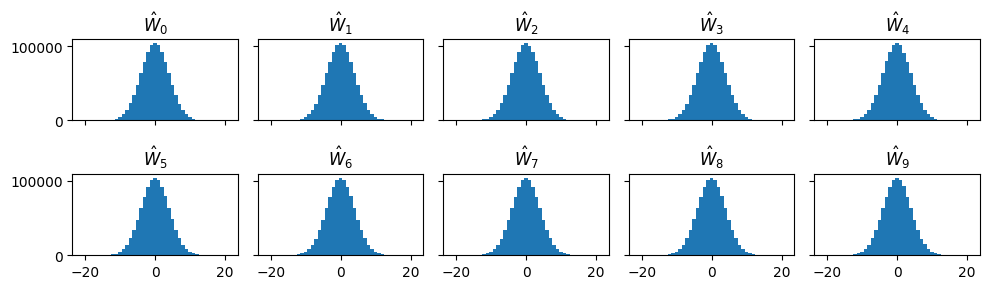

In [13]:
np.random.seed(20250310)
matrices = np.random.randn(10, 1024, 1024)
quantized_matrices = np.round(matrices * 4).astype(np.int8)
print(f'mins: {quantized_matrices.min(axis=(1, 2))}')
print(f'maxs: {quantized_matrices.max(axis=(1, 2))}')

fig, axs = plt.subplots(2, 5, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)
bins = np.arange(-np.abs(quantized_matrices).max() - 0.5, np.abs(quantized_matrices).max() + 1.5)
for i, ax in enumerate(axs.flat):
    ax.hist(quantized_matrices[i ].ravel(), bins=bins)
    ax.set_title(r'$\hat{W}_{' + str(i ) + r'}$')

vector = np.round(np.random.randn(1024) * 4).astype(np.int8)

## Create Entropy Models

In [14]:
def create_entropy_model(data, precision):
    min_value = data.min().item()
    max_value = data.max().item()

    if min_value == max_value:
        # Special case: all values are the same. Due to a limitation of ANS coding, we have
        # to create a dummy extra grid point with the smallest possible nonzero probability.
        grid_size = 2
        cdf = np.array([0, (1 << precision) - 1, 1 << precision], dtype=np.uint16)
        entropy = 0
        # To avoid loss of precision, we use `log1p(x) := log(1 + x)`, and thus:
        # cross_entropy = - log2((2^p - 1) / 2^p) = - log2(1 - 1 / 2^p) = - log1p(-1 / 2^p) / log(2)
        cross_entropy = - np.log1p(-1 / (1 << precision)) / np.log(2)
    else:
        grid_size = max_value - min_value + 1
        values, counts = np.unique(data, return_counts=True)

        # Sort descendingly by `counts`.
        order = np.argsort(counts)[::-1]
        values = values[order]
        counts = counts[order]

        scale = (1 << precision) / data.size
        probs = np.maximum(1, np.round(counts * scale).astype(np.uint16))

        excess = sum(probs).item() - (1 << precision)
        if excess > 0:
            # Shave off some probability mass from the most probable entries
            assert excess <= len(counts)
            while excess > 0:
                num_reducible_entries = (probs > 1).sum()
                num_reduce = min(excess, num_reducible_entries)
                assert num_reduce > 0
                probs[:num_reduce] -= 1
                excess -= num_reduce
            probs[:excess] -= 1
        elif excess < 0:
            # Spread some probability mass to the least probable entries.
            probs[excess:] += 1

        assert probs.sum() == 1 << precision

        entropy = np.log2(data.size) - (counts @ np.log2(counts)) / data.size
        cross_entropy = precision - (counts @ np.log2(probs)) / data.size

        padded_pmf = np.zeros(grid_size + 1, dtype=np.uint16)
        for value, prob in zip(values, probs):
            padded_pmf[value - min_value + 1] = prob

        cdf = np.cumsum(padded_pmf, dtype=np.uint16)
        assert cdf[0] == 0
        assert cdf[-1] == 1 << precision

    return min_value, grid_size, cdf, entropy, cross_entropy

### Evaluate Overhead for Various `precision`s

100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


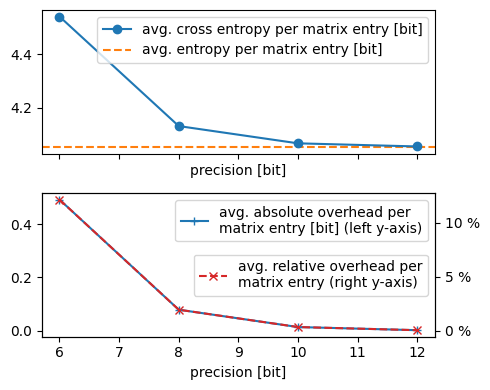

In [15]:
precisions = [6, 8, 10, 12]
avg_cross_entropies = []

for precision in tqdm(precisions):
    entropies = []
    cross_entropies = []

    for matrix in quantized_matrices:
        min_value, grid_size, cdf, entropy, cross_entropy = create_entropy_model(matrix, precision)
        entropies.append(entropy)
        cross_entropies.append(cross_entropy)

    avg_cross_entropies.append(np.mean(cross_entropies))

avg_entropy = np.mean(entropies)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), sharex=True, tight_layout=True)
ax1.plot(precisions, avg_cross_entropies, 'o-', label='avg. cross entropy per matrix entry [bit]')
xlims = ax1.get_xlim()
ax1.hlines(avg_entropy, *xlims, 'tab:orange', '--', label='avg. entropy per matrix entry [bit]', zorder=-1)
ax1.set_xlim(*xlims)

ax2.plot(precisions, np.array(avg_cross_entropies) - avg_entropy, '+-', label='avg. absolute overhead per\nmatrix entry [bit] (left y-axis)')
ax2r = ax2.twinx()
ax2r.plot(
    precisions,
    np.array(avg_cross_entropies) / avg_entropy - 1,
    'x--',
    color='tab:red',
    label='avg. relative overhead per\nmatrix entry (right y-axis)'
)

ax1.set_xlabel('precision [bit]')
ax2.set_xlabel('precision [bit]')

ax1.legend()
ax2.legend(loc='upper right')
ax2r.legend(loc='upper right', bbox_to_anchor=(1, 0.62))
ax2r.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f} %')) 

## Entropy Coder

In [16]:
class AnsCoder:
    def __init__(self, precision, word_size, compressed=[]):
        self.precision = precision
        self.word_size = word_size
        self.word_mask = (1 << word_size) - 1
        self.quantile_mask = (1 << precision) - 1
        self.bulk = compressed.copy()
        self.head = 0
        while len(self.bulk) != 0 and (self.head >> word_size) == 0:
            self.head = (self.head << word_size) | self.bulk.pop()

    def push(self, symbol, cdf):
        prob = (cdf[symbol + 1] - cdf[symbol]).item()
        if (self.head >> (2 * self.word_size - self.precision)) >= prob:
            self.bulk.append(self.head & self.word_mask)
            self.head >>= self.word_size

        # print(f'pushing {symbol} with prob {prob} and cdf {cdf[symbol]} onto {self.head}')
        z = self.head % prob + cdf[symbol].item()
        self.head = ((self.head // prob) << self.precision) | z

    def pop(self, cdf):
        z = self.head & self.quantile_mask
        self.head >>= self.precision
        symbol = cdf.searchsorted(z, side='right').item() - 1
        prob = (cdf[symbol + 1] - cdf[symbol]).item()
        self.head = self.head * prob + (z - cdf[symbol].item())
        if (self.head >> self.word_size) == 0 and len(self.bulk) != 0:
            self.head = (self.head << self.word_size) | self.bulk.pop()
        return symbol

    def get_compressed(self):
        compressed = self.bulk.copy()
        head = self.head
        while head != 0:
            compressed.append(head & self.word_mask)
            head >>= self.word_size
        return compressed
    
    def interrupt(self):
        while self.head != 0:
            self.bulk.append(self.head & self.word_mask)
            self.head >>= self.word_size
        self.head = 1 << self.word_size
        return len(self.bulk)

## Compress the Matrices

In [17]:
class CompressedMatrix:
    def __init__(self, rows, cols, grid_spacing, cursors, min_value, cdf, payload):
        self.rows = rows
        self.cols = cols
        self.grid_spacing = grid_spacing
        self.cursors = cursors
        self.min_value = min_value
        self.cdf = cdf
        self.payload = payload # unpadded; will be padded to an even length upon serialization.
    
    def compressed_word_count(self):
        payload_size = len(self.payload) + len(self.payload) % 2
        return (4 + self.rows) * 2 + (3 + len(self.cdf)) // 2 + payload_size

    def serialize(self, file):
        payload_size = len(self.payload) + len(self.payload) % 2
        file.write(struct.pack(
            f'<LLf{self.rows}LLbB{len(self.cdf)}B',
            self.rows,
            self.cols,
            self.grid_spacing,
            *self.cursors,
            payload_size,
            self.min_value,
            len(self.cdf) - 1,
            *(self.cdf & 0xFF),
        ))

        if len(self.cdf) % 2 == 1:
            file.write(b'\0')

        if sys.byteorder == 'little':
            self.payload.tofile(file)
        else:
            self.payload.byteswap().tofile(file)

        if len(self.payload) % 2 == 1:
            file.write(b'\0\0')


In [18]:
def encode_matrix(matrix, precision = 8):
    min_value, _grid_size, cdf, _entropy, _cross_entropy = create_entropy_model(matrix, precision)
    coder = AnsCoder(precision, 16, [0, 1])
    back_cursors = np.empty(matrix.shape[0], dtype=np.uint32)

    for row in range(matrix.shape[0] - 1, -1, -1): # iterates in reverse order
        for entry in matrix[row, ::-1]: # iterates in reverse order
            coder.push(entry.item() - min_value, cdf)
        back_cursors[row] = coder.interrupt()
    
    payload = np.array(coder.bulk[::-1], dtype=np.uint16)
    cursors = len(payload) - back_cursors
    return CompressedMatrix(matrix.shape[0], matrix.shape[1], 1.0, cursors, min_value, cdf, payload)

In [19]:
encoded_matrices = [encode_matrix(matrix) for matrix in tqdm(quantized_matrices)]

100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


## Serialize to a file

In [20]:
def serialize_file_header(file, num_matrices, max_word_count):
    file.write(struct.pack('<LL', num_matrices, max_word_count))

def serialize_vector(file, vec):
    file.write(struct.pack('<L', len(vec)))
    if sys.byteorder == 'little':
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

In [21]:
max_word_count = max(m.compressed_word_count() for m in encoded_matrices)

with open('compressed_matrices.bin', 'wb') as file:
    serialize_file_header(file, len(quantized_matrices), max_word_count)
    serialize_vector(file, vector)
    for matrix in encoded_matrices:
        matrix.serialize(file)

!ls -l compressed_matrices.bin
!ls -lh compressed_matrices.bin

-rw-r--r-- 1 wildug wildug 5486680 24. Mär 23:37 compressed_matrices.bin
-rw-r--r-- 1 wildug wildug 5,3M 24. Mär 23:37 compressed_matrices.bin


In [22]:
54919400 * 8 / (len(quantized_matrices) * 1024**2), avg_cross_entropies, avg_entropy

(41.900177001953125,
 [4.542749963947324, 4.130124855985332, 4.065092305783992, 4.053324527799759],
 4.050833310206473)

## Debugging

In [23]:
# Checksum adapted from rust's FxHash, but restricted to 26 bit hashes so that the
# multiplication doesn't exceed the range of exactly representable integers in JavaScript.
def get_checksum(data):
    checksum = 0
    for value in data.ravel():
        # Convert `value` into a unique positive value to avoid architecture- and
        # precision-dependent behavior in the bit manipulations below.
        value = value.item()
        if value < 0:
            # Negative `value`s are mapped to odd positive numbers ...
            value = -2 * value + 1
        else:
            # ... and positive `value`s are mapped to even positive numbers.
            value = 2 * value

        checksum = ((checksum & 0x001f_ffff) << 5) | (checksum >> 21) # rotate
        checksum = (checksum ^ value) * 0x0322_0a95
        checksum = checksum & 0x03ff_ffff # truncate to 26 bit
    return checksum

In [24]:
print(f'checksum of vector: {get_checksum(vector)}')

for i, quantized_matrix in enumerate(quantized_matrices):
    print(f'checksum of matrix {i}: {get_checksum(quantized_matrix)}')

checksum of vector: 26276841


checksum of matrix 0: 14003483
checksum of matrix 1: 46459754
checksum of matrix 2: 62940825
checksum of matrix 3: 24228632
checksum of matrix 4: 22964300
checksum of matrix 5: 25327833


KeyboardInterrupt: 